<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0410_No_test_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount, Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os, re, string, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, concatenate, add
from tensorflow.keras.layers import Conv1D, GRU, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# Load Data

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/train.csv/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/test.csv/test.csv')

In [ ]:
train_fr = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_fr.csv')
train_de = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_de.csv')
train_es = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_es.csv')

In [ ]:
train_fr_toxic = train_fr[train_fr.iloc[:, 2:8].sum(1) != 0]
train_de_toxic = train_de[train_de.iloc[:, 2:8].sum(1) != 0]
train_es_toxic = train_es[train_es.iloc[:, 2:8].sum(1) != 0]

In [ ]:
train_fr_toxic.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU MISS IN MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey ... what is it ..\n@ | speak .\nWhat is it...,1,0,0,0,0,0


In [ ]:
train_augumented = pd.concat([train, train_fr_toxic, train_de_toxic, train_es_toxic],ignore_index=True)

In [ ]:
train_augumented.shape

(208246, 8)

# Preprocessing

In [ ]:
train_augumented['preprocessed'] = train_augumented['comment_text']

## Train data

In [ ]:
# 1. Capitalization / Lower case'
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
!pip install contractions
import contractions
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: x.lower())
# # Remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

     |████████████████████████████████| 266kB 4.2MB/s 
     |████████████████████████████████| 327kB 17.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85399 sha256=df35980521fd88c677bee41b1ee1eb976e0de2d62363c6744dc393a683a314c4
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Find zero len comment
zerolen_t = list()
num = 0
for i in train_augumented['preprocessed']:
  if not re.search('\S',i):
    zerolen_t.append(num)
  num += 1
print(len(zerolen_t))  # 전처리 되어서 ' ' 형태된 갯수 

51


In [ ]:
pd.set_option('max_colwidth', 200)
pd.set_option("max_rows", None)
train_augumented.iloc[zerolen_t,1:]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed
2407,"Here, here and here.",0,0,0,0,0,0,
9395,They do too. their ... -,0,0,0,0,0,0,
12414,You're just at it again!,0,0,0,0,0,0,
19815,(www.ebenefits.va.gov),0,0,0,0,0,0,
23095,Where was it before?,0,0,0,0,0,0,
26401,than just on/off such as on/off/,0,0,0,0,0,0,
31072,!!!!!\nWhat is all of this.,0,0,0,0,0,0,
32019,"""\nNo, they DON'T! """,0,0,0,0,0,0,
36755,I wont do it again,0,0,0,0,0,0,
38313,what \n\nwhy did you do that!!,0,0,0,0,0,0,


In [ ]:
train_augumented.iloc[zerolen_t,8] = 'useless'

In [ ]:
train_augumented.iloc[zerolen_t,[1,8]].head(10)

,comment_text,preprocessed
2407,"Here, here and here.",useless
9395,They do too. their ... -,useless
12414,You're just at it again!,useless
19815,(www.ebenefits.va.gov),useless
23095,Where was it before?,useless
26401,than just on/off such as on/off/,useless
31072,!!!!!\nWhat is all of this.,useless
32019,"""\nNo, they DON'T! """,useless
36755,I wont do it again,useless
38313,what \n\nwhy did you do that!!,useless


In [ ]:
from sklearn.utils import shuffle
train_augumented = shuffle(train_augumented)

In [ ]:
train_augumented.to_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-new-train.csv", index=False)

# New Train Data


In [ ]:
train_augumented = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-new-train.csv")
train_augumented.head(2)

# Tokenization

In [ ]:
list_sentences_train = train_augumented['preprocessed'] # (208246,)
list_sentences_test = test['comment_text'] # (153164,)

In [ ]:
max_features = 50000
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

177533

# Padding

In [ ]:
train_augumented['length'] = train_augumented['preprocessed'].apply(lambda x: len(x.split()))
test['length'] = test['comment_text'].apply(lambda x: len(x.split()))

In [ ]:
train_augumented['length'].quantile([.8])

0.8    43.0
Name: length, dtype: float64

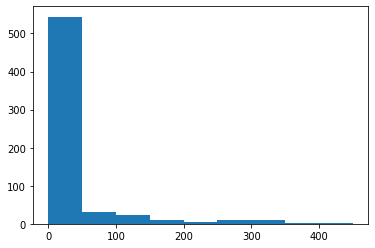

In [ ]:
plt.hist(train_augumented['length'].value_counts(),bins = np.arange(0,500,50))
plt.show()

In [ ]:
test['length'].quantile([.8])

0.8    81.0
Name: length, dtype: float64

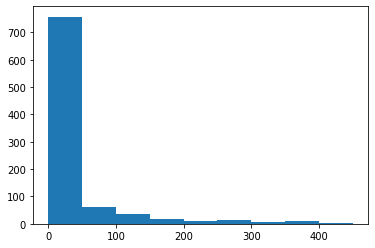

In [ ]:
plt.hist(test['length'].value_counts(),bins = np.arange(0,500,50))
plt.show()

In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (208246, 100)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 100)

X_t.shape

(208246, 100)

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (208246, 6)
y.shape

(208246, 6)

# Pretrained-Embedding-matrix

In [ ]:
embedding_dict = dict()
f = open('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/glove.twitter.27B.200d.txt/glove.twitter.27B.200d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 200
    embedding_dict[word] = word_vector_arr
f.close()
print('There are %s Embedding Vectors\n' % len(embedding_dict))

print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200)) # will delete first row

for word, i in tokenizer.word_index.items(): 
    temp = embedding_dict.get(word) 
    if temp is not None:
        embedding_matrix[i] = temp 

print(embedding_matrix.shape)
embedding_matrix = np.delete(embedding_matrix,0,axis=0) # delete first row
print(embedding_matrix.shape)

There are 1193514 Embedding Vectors

[-6.4748e-01 -3.7296e-01 -3.6128e-01  7.9975e-01 -2.1890e-01  7.6152e-01
 -7.3698e-02  2.2635e-01 -7.5429e-02  6.3600e-01 -6.5914e-01 -5.1787e-01
 -6.4411e-02 -3.0796e-01  4.4071e-01  1.4543e-01 -9.9792e-02 -2.3253e-01
  2.0882e-01 -9.3256e-02 -2.9659e-01 -1.6643e-01 -1.3184e-01 -5.5247e-01
 -6.0625e-01  9.6745e-01  3.8410e-01 -1.4236e-02  2.8774e-01  7.5652e-01
  1.1552e-01 -4.9894e-01 -9.2585e-02 -6.7708e-02  3.1373e-01  5.6426e-01
  1.9797e-01  4.0703e-02  2.7106e-01 -3.3045e-01  3.9652e-01  1.3718e-01
  5.0194e-01  3.7811e-01  2.9139e-01  2.6001e-01  2.9927e-01  3.6737e-01
  1.0638e-01  3.7086e-01  2.3767e-02  6.4266e-01 -2.4067e-01 -3.1749e-01
 -3.4070e-01  9.3053e-01  1.8900e-01 -2.7260e-01 -3.5132e-01  1.4086e-01
 -1.6232e-01  8.7983e-03 -8.7401e-02 -1.2887e-01  2.5303e-01  9.0737e-01
 -3.3149e-01  5.8059e-02 -2.3855e-01  3.5351e-01 -3.8560e-01 -4.6745e-01
 -2.2487e-01 -1.9058e-01  3.4685e-02  4.1231e-01  9.3602e-02  2.0409e-01
 -2.4806e-01  

In [ ]:
np.save('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0410-final-200d-pretrained-embed-Glove.npy',embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0410-final-200d-pretrained-embed-Glove.npy')
embedding_matrix.shape

(177533, 200)

# Model

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dropout(0.2)(conc)
x = Dense(64, 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     35506600    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     336896      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-final-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 30
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/30
1465/1465 [==============================] - 127s 65ms/step - loss: 0.2385 - accuracy: 0.8906 - val_loss: 0.1442 - val_accuracy: 0.9830

Epoch 00001: val_loss improved from inf to 0.14418, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-final-pretrained-embed-Glove.hdf5
Epoch 2/30
1465/1465 [==============================] - 93s 64ms/step - loss: 0.1505 - accuracy: 0.9797 - val_loss: 0.1287 - val_accuracy: 0.9830

Epoch 00002: val_loss improved from 0.14418 to 0.12869, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-final-pretrained-embed-Glove.hdf5
Epoch 3/30
1465/1465 [==============================] - 93s 64ms/step - loss: 0.1350 - accuracy: 0.9809 - val_loss: 0.1207 - val_accuracy: 0.9819

Epoch 00003: val_loss improved from 0.12869 to 0.12069, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-final-pretrained-embed-Glove.hdf5
Epoch 4/30
1465/1465 [==============================] - 94s 6

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-final-pretrained-embed-Glove.csv", index=False)